In [1]:
import sys, jax
import os

# show GPUs again (or pick specific ones)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # or "0,1" … ; delete the var to expose all

# tell JAX to use CUDA (JAX 0.5.* prefers this env var)
os.environ["JAX_PLATFORMS"] = "cuda"

# if you previously set the old name, clear it
os.environ.pop("JAX_PLATFORM_NAME", None)

print(sys.executable)      # should be .../miniconda3/envs/clean_cmb/bin/python
print(jax.__version__)     # 0.5.x
print(jax.devices())       # [CudaDevice(...)]

/home/agnes/miniconda3/envs/clean_cmb/bin/python
0.5.3
[CudaDevice(id=0), CudaDevice(id=1)]


In [2]:
'''
import os
# Prefer CPU
os.environ["JAX_PLATFORMS"] = "cpu"      # JAX 0.5+ preferred flag
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # optional: hide all GPUs from JAX & CUDA
os.environ.pop("JAX_PLATFORM_NAME", None)  # ensure old flag isn't forcing cuda

import jax
print(jax.__version__)
print(jax.devices())   # should show [CpuDevice(0)]
'''

'\nimport os\n# Prefer CPU\nos.environ["JAX_PLATFORMS"] = "cpu"      # JAX 0.5+ preferred flag\nos.environ["CUDA_VISIBLE_DEVICES"] = ""  # optional: hide all GPUs from JAX & CUDA\nos.environ.pop("JAX_PLATFORM_NAME", None)  # ensure old flag isn\'t forcing cuda\n\nimport jax\nprint(jax.__version__)\nprint(jax.devices())   # should show [CpuDevice(0)]\n'

In [3]:
import os, sys
os.chdir("/home/agnes/Skyclean")       # repo root
sys.path.insert(0, os.getcwd())

from skyclean.silc.ilc import ProduceSILC
from skyclean.silc.ilc import SILCTools
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.pipeline import Pipeline

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [4]:
import numpy as np

# --- Physical constants ---
h = 6.62607015e-34        # Planck [J·s]
k = 1.380649e-23          # Boltzmann [J/K]
T_cmb = 2.7255            # [K]

# --- Planck frequency channels in GHz ---
frequencies = ['030','044','070','100','143','217','353','545','857']
nu = np.array([float(f) for f in frequencies]) * 1e9   # Hz
x = h * nu / (k * T_cmb)

# Unit conversion (antenna→thermodynamic), proportional to dB/dT
g_nu = (x**2 * np.exp(x)) / (np.exp(x) - 1.0)**2

# (a) CMB in thermodynamic units: flat response
cmb_vec = np.ones_like(nu)

# (b) tSZ in thermodynamic units
tsz_vec = x * ((np.exp(x) + 1) / (np.exp(x) - 1)) - 4
# Optional: tsz_vec is ~0 near 217 GHz automatically; don't zero 30/44/70.

# (c) Synchrotron: antenna T ∝ ν^β, convert to thermodynamic
beta_s = -3.1
nu0 = 30e9
T_sync_ant = (nu / nu0) ** beta_s
sync_vec = T_sync_ant / g_nu

# Normalize columns (helps matching)
def _norm(v): 
    n = np.linalg.norm(v)
    return v if n == 0 else (v / n)

reference_vectors = {
    "cmb":  _norm(cmb_vec),
    "tsz":  _norm(tsz_vec),
    "sync": _norm(sync_vec),
}

# Column order in F (controls what “column index” each name maps to)
F_cols = ["cmb", "tsz", "sync"]
F = np.column_stack([reference_vectors[name] for name in F_cols])  # shape (Nfreq, Nc)

def build_f(F, component_name):
    """Return unit vector f (Nc,) with 1 at the column corresponding to component_name."""
    # allow list/tuple to mean multiple constraints; here: single name
    if isinstance(component_name, (list, tuple)):
        raise ValueError("build_f expects a single name; pass one of: " + ", ".join(F_cols))
    try:
        j = F_cols.index(component_name.lower())
    except ValueError:
        raise ValueError(f"Component '{component_name}' not in F columns {F_cols}")
    f = np.zeros(F.shape[1], dtype=float)
    f[j] = 1.0
    return f


In [5]:
print("F columns:", F_cols)
print("f for cmb:", build_f(F, "cmb"))
print("f for tsz:", build_f(F, "tsz"))
print("f for sync:", build_f(F, "sync"))

F columns: ['cmb', 'tsz', 'sync']
f for cmb: [1. 0. 0.]
f for tsz: [0. 1. 0.]
f for sync: [0. 0. 1.]


In [6]:
directory = "/Scratch/agnes/data" 
ft = FileTemplates(directory).file_templates

# INPUT wavelet coeff template (uses {comp}, {frequency}, {scale}, {realisation:05d}, {lmax}, {lam})
file_template = ft.get("wavelet_coeffs") or ft["wavelet_c_j"]

# OUTPUT templates expected by ILC_wav_coeff_maps_MP (use {component}, {extract_comp}, {realisation})
output_templates = {
    "doubled_maps":           ft["doubled_maps"],
    "covariance_matrices":    ft["covariance_matrices"],
    "weight_vector_matrices": ft["weight_vector_matrices"],
    "ilc_maps":               ft["ilc_maps"],
    "trimmed_maps":           ft["trimmed_maps"],
    "ilc_synth":              ft["ilc_synth"],
    "ilc_spectrum":           ft.get("ilc_spectrum"),  
    "scaling_coeffs":         ft["scaling_coeffs"], 
}

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

pipe = Pipeline(
    components=["cmb","sync","noise","tsz"],
    wavelet_components=["cfn"],
    ilc_components=["cmb"],
    frequencies=["030","044","070","100","143","217","353","545","857"],
    realisations=1,
    start_realisation=0,
    lmax=64,
    N_directions=1,
    lam=2.0,
    method="jax_cuda",
    visualise=True,
    save_ilc_intermediates=False,
    overwrite=False,
    directory="/Scratch/agnes/data",
    # constrained ILC controls:
    constraint=True,
    F=F,
    reference_vectors=reference_vectors,
    )

In [8]:
pipe.step_download()

--- STARTING DATA DOWNLOAD ---
File /Scratch/agnes/data/CMB_realisations/sync_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f044.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f070.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f100.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f143.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f217.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f353.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f545.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/sync_f857.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f044

In [9]:
pipe.step_process()

--- PROCESSING CFNs AND TOTAL MAP CFN ---
CFN map at 030 GHz for realisation 0 already exists. Skipping processing.
CFN map at 044 GHz for realisation 0 already exists. Skipping processing.
CFN map at 070 GHz for realisation 0 already exists. Skipping processing.
CFN map at 100 GHz for realisation 0 already exists. Skipping processing.
CFN map at 143 GHz for realisation 0 already exists. Skipping processing.
CFN map at 217 GHz for realisation 0 already exists. Skipping processing.
CFN map at 353 GHz for realisation 0 already exists. Skipping processing.
CFN map at 545 GHz for realisation 0 already exists. Skipping processing.
CFN map at 857 GHz for realisation 0 already exists. Skipping processing.


In [10]:
pipe.step_wavelets()

--- PRODUCING WAVELET TRANSFORMS ---
Wavelet coefficients for cfn at 030 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 030 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 044 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 044 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 070 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 070 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 100 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 100 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 143 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 143 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 217 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 217 GHz for realisation 0 saved.
Wavelet coefficients for cf

--- RUNNING ILC (new functional API) ---
--- ILC target='cmb'  input='cfn'  lmax=64  scales=[0, 1, 2, 3, 4, 5, 6, 7, 8] ---
Processing realisation 0000 for component cfn
load_frequency_data
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s0_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s1_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s2_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s3_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s4_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s5_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s6_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s7_r0000_lmax64_lam2.0.npy
saved: /Scratch/agnes/data/SILC/doubled_maps/doubled_cfn_f030_s8_r0000_lmax64_lam2.0.npy
saved: /S

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariancecompute_covariance
smoothed_covariance

smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatical

compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariancecompute_covariance
smoothed_covariance

smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smooth

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smooth

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.
JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariancecompute_covariance
smoothed_covariance

smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smooth

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smoothed_covariance
compute_covariance
smooth

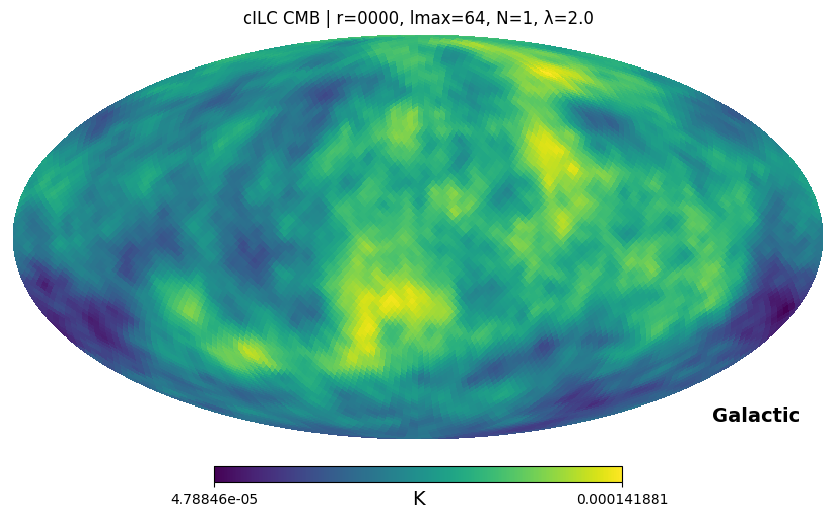

FINAL CHECK  F^T w == f  -> True


In [11]:
pipe.step_ilc()

In [12]:
'''
import os

# Use the SAME base directory you used for Pipeline(...)
BASE_DIR = "/Scratch/agnes/data"

templates = FileTemplates(directory=BASE_DIR)
ft = templates.file_templates

# INPUT template must be the wavelet coeff pattern (matches what step_wavelets saved)
file_template = ft["wavelet_coeffs"]  # "{comp}_wavelet_f{frequency}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"

# OUTPUT templates for ILC
output_templates = {
    "doubled_maps":           ft["doubled_maps"],
    "covariance_matrices":    ft["covariance_matrices"],
    "weight_vector_matrices": ft["weight_vector_matrices"],
    "ilc_maps":               ft["ilc_maps"],
    "trimmed_maps":           ft["trimmed_maps"],
    "ilc_synth":              ft["ilc_synth"],
    "ilc_spectrum":           ft.get("ilc_spectrum"),
}

# Sanity check: one file we expect to exist after step_wavelets()
probe = file_template.format(
    comp="cfn", frequency="030", scale=0,
    realisation=0, lmax=64, lam="2.0"
)
print("Probing:", probe, "->", os.path.exists(probe))

target_components = "cmb"
scales = list(range(0, 9))
realisations = [0]   # IMPORTANT: integers, because the template uses {realisation:05d}

constrained_maps = ProduceSILC.ILC_wav_coeff_maps_MP(
    file_template=file_template,
    frequencies=["030","044","070","100","143","217","353","545","857"],
    scales=scales,
    realisations=realisations,          # ints, not "0000"
    output_templates=output_templates,
    L_max=64,
    N_directions=1,
    comp="cfn",
    constraint=True,
    F=F,
    extract_comp=target_components,
    reference_vectors=reference_vectors,    
    )
'''

'\nimport os\n\n# Use the SAME base directory you used for Pipeline(...)\nBASE_DIR = "/Scratch/agnes/data"\n\ntemplates = FileTemplates(directory=BASE_DIR)\nft = templates.file_templates\n\n# INPUT template must be the wavelet coeff pattern (matches what step_wavelets saved)\nfile_template = ft["wavelet_coeffs"]  # "{comp}_wavelet_f{frequency}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"\n\n# OUTPUT templates for ILC\noutput_templates = {\n    "doubled_maps":           ft["doubled_maps"],\n    "covariance_matrices":    ft["covariance_matrices"],\n    "weight_vector_matrices": ft["weight_vector_matrices"],\n    "ilc_maps":               ft["ilc_maps"],\n    "trimmed_maps":           ft["trimmed_maps"],\n    "ilc_synth":              ft["ilc_synth"],\n    "ilc_spectrum":           ft.get("ilc_spectrum"),\n}\n\n# Sanity check: one file we expect to exist after step_wavelets()\nprobe = file_template.format(\n    comp="cfn", frequency="030", scale=0,\n    realisation=0, lmax=64, lam